In [1]:
import os

import glob
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from functools import reduce
from pathlib import Path
import dcor 

import plotly.io as pio
pio.renderers.default='notebook'

%load_ext autoreload
%autoreload 2

## Functions

In [2]:
# RUN THIS CELL
# FUNCTIONS
from hbn import io
from hbn.data import make_dataset
from hbn.features import feature_selection
from hbn.constants import Defaults

def get_answers(feature_specs, participants=None, diagnoses=None, split='all'):
    """get answers from `feature_specs` returned as a list of dataframes
    
    Args:
        feature_specs (list of str): fullpaths to feature specs
        diagnoses (list of str): (optional) list of diagnoses from `model_specs`. for example `diagnoses = ['ADHD-Combined Type']`
    Returns:
        df_list (list of pd dataframes): list of dataframes
    """
    
    if diagnoses is None:
        diagnoses = ['No_Diagnosis_Given']
        
    participants = make_dataset.get_participants(
                                split=split, 
                                disorders=diagnoses
                                            )
    # loop over feature specs 
    df_list = []; same_part = []
    for feature_spec in feature_specs:

        # load feature spec
        spec_info = io.read_json(os.path.join(Defaults.FEATURE_DIR, feature_spec))
        spec_info['preprocessing'] = None # not doing preprocessing as defined in the feature spec file

        # get data
        df = feature_selection.phenotype_features(target_spec=None,
                                feature_spec=spec_info,
                                participants=participants,
                                preprocess=True,
                                drop_identifiers=False,
                                oversample=False
                                ).reset_index(drop=True)
        df = df.drop_duplicates(subset=['Identifiers'])
        df_list.append(df)
        same_part.append(df['Identifiers'])

    part_intersect = list(reduce(set.intersection, map(set, same_part)))

    # index dataframes for `part_intersect`
    df_out = []
    for df in df_list:
        df_part = df[df['Identifiers'].isin(part_intersect)]
        df_part = df_part.drop(columns=['Identifiers'])
        df_out.append(df_part)
    
    return df_out

def get_questions(feature_specs):
    
    # loop over features
    df_list = []
    for feature_spec in feature_specs:
        spec_info = io.read_json(os.path.join(Defaults.FEATURE_DIR, feature_spec))
        
        # get abbreviations
        abbrev = spec_info['datadic']
        
        # load in excel file of data dictionary
        df_Q = pd.read_excel(os.path.join(Defaults.PHENO_DIR, 'Release9_DataDic',  f'{abbrev}.xlsx'), header=1)
        df_Q.columns = [col.strip(' ') for col in df_Q]
        df_list.append(df_Q)
            
    return df_list
            

def sentence_similarity(sentences):
    """calculate sentence similarity across all sentence combinations
    
    Args:
        sentences (list): list of sentences
    """
    from sentence_transformers import SentenceTransformer, util
    
    # get model
    model = SentenceTransformer('distilbert-base-nli-mean-tokens')

    # calculate sentence embeddings
    sentence_embeddings = model.encode(sentences)
    
    #Compute cosine-similarities for each sentence with each other sentence
    cosine_scores = util.cos_sim(sentence_embeddings, sentence_embeddings)
    
    #Find the pairs with the highest cosine similarity scores
    pairs = []
    for i in range(len(cosine_scores)-1):
        for j in range(i+1, len(cosine_scores)):
            pairs.append({'index': [i, j], 'score': cosine_scores[i][j]})

    #Sort scores in decreasing order
    pairs = sorted(pairs, key=lambda x: x['score'], reverse=True)
    
    return cosine_scores, pairs

def answer_similarity(dataframe, pairs):
    """calculate correlations across answers for all `pairs` of sentences
    
    Args:
        dataframe (pd dataframe):
        pairs (list of dict): output from `sentence_similarity`
    """
    
    # calculate correlations across answers
    df_corr = dataframe.corr()
    
    pairs_A = []
    for idx in range(len(pairs)):
        r = pairs[idx]['index'][0]
        c = pairs[idx]['index'][1]
        rcorr = df_corr.iloc[r,c]
        pairs_A.append(rcorr)
    
    return pairs_A

def distance_correlation_permutation(x, y, n_tests=100, n_samples=1000, dim=30, significance=0.1, n_obs_list=[25, 30, 35, 50, 70, 100]):
    import scipy
    import dcor
    
    table = pd.DataFrame()
    table["n_obs"] = n_obs_list

    dist_results = []
    for n_obs in n_obs_list:
        n_errors = 0
        statistics = []
        for _ in range(n_tests):
            x = np.random.normal(0, 1, size=(n_samples, dim))
            y = np.random.normal(0, 1, size=(n_samples, dim))

            test_result = dcor.independence.distance_correlation_t_test(x, y)
            statistics.append(test_result.statistic)
            if test_result.pvalue < significance:
                n_errors += 1

        error_prob = n_errors / n_tests
        dist_results.append(error_prob)

    table["Type I error"] = dist_results

    # Plot the last distribution of the statistic
    df = len(x) * (len(x) - 3) / 2

    plt.hist(statistics, bins=12, density=True)

    distribution = scipy.stats.t(df=df)
    u = np.linspace(distribution.ppf(0.01), distribution.ppf(0.99), 100)
    plt.plot(u, distribution.pdf(u))
    plt.show()

    table
    
def distance_covariance_permutation(x,y):
    import time
    import dcor
    
    random_state = 42
    num_resamples_list = [10, 50, 100, 200, 500]

    pvalues = []
    times = []

    for num_resamples in num_resamples_list:

        start_time = time.monotonic()
        test_result = dcor.independence.distance_covariance_test(
            x,
            y,
            num_resamples=num_resamples,
            random_state=random_state,
        )
        end_time = time.monotonic()

        pvalues.append(test_result.pvalue)
        times.append(end_time - start_time)

    fig, axes = plt.subplots(2, 1, sharex=True)
    axes[0].plot(num_resamples_list, pvalues)
    axes[1].plot(num_resamples_list, times, color="C1")
    axes[1].set_xticks(num_resamples_list)
    axes[1].set_xlabel("number of permutations")
    axes[0].set_ylabel("p-value")
    axes[1].set_ylabel("time (in seconds)")
    plt.show()

def plot_heatmap(array, labels=None):
    """plot heatmap of array with labels (optional)
    
    Args:
        array (np array):
        labels (list of str or None): optional
    """
    ax = sns.heatmap(array)
    
    if labels is not None:
        ax.set_xticklabels(
            labels,
            rotation=45,
            horizontalalignment='right'
            )
        ax.set_yticklabels(
            labels,
            rotation=360,
            horizontalalignment='right'
        )

    plt.show()
    
def dendrogram_plot(dataframe, method='ward', metric='euclidean', labels=None, reorder=False, orientation='top', color_leaves=True, ax=None):
    """ Plots dendrogram plot.
        
        Args:
            dataframe: dataframe is output from ana.return_grouped_data or ana.return_thresholded_data
            method (str): 'ward' # there are other options given by linkage
            metric (str): 'euclidean' # there are other options given by linkage
            ax (bool): figure axes. Default is None
            color_leaves (bool): whether or not leaf nodes should be colored
            orientation (str): how the dendrogram should be oriented. Default is 'top'. Other options are 'right', 'left'
            reorder (bool): reorders the expression matrix before being input to clustering algo
    """
    from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, set_link_color_palette
    
    if ax is None:
        plt.figure(num=1, figsize=[25,8])

    if reorder:
        dataframe = _reorder_dendrogram_leaves(dataframe)

    if color_leaves:
        set_link_color_palette(['b', 'r', 'y', 'm'])
    else:
        set_link_color_palette(['k', 'k', 'k', 'k'])
        
    if labels is not None:
        labels = dataframe.index.to_list()

    R = dendrogram(
        Z=linkage(dataframe, method, metric),
        orientation=orientation,
        get_leaves=True,
        color_threshold=35.0,
        labels=labels,
        distance_sort='ascending',
        above_threshold_color='black', 
        ax=ax, 
        )

    # plt.title("Hierarchical Clustering Dendrogram", fontsize=20)
    plt.xlabel('')
    plt.ylabel(f"{metric.capitalize()} Distance")

    return R
    
def plot_top_sentences(pairs, sentences, A_similarity=None, percent=10, title=None):
    """plot most similar sentences in a tabular format
    
    Args:
        pairs (list of dict): output from `sentence similarity`
        sentences (list of str): list of sentences
        A_similarity (list of str or None): (optional) output from `answer_similarity`
        percent (int): percentage of top sentences to print
    """
    from tabulate import tabulate
    
    pairs_all = pairs
    header = ["Sentence 1", "Sentence 2", "Question"]
    
    if A_similarity is not None:
        # add answer similarity score to `pairs` dictionary
        pairs_all = []
        header = ["Sentence 1", "Sentence 2", "Question", "Answer"]
        for r, score in zip(pairs, A_similarity):
            r.update({'score_A': score})
            pairs_all.append(r)

    #Output the pairs with their score
    top_sentences = []
    num_sentences = int(len(sentences)*percent/100)
    for pair in pairs_all[0:num_sentences]:
        i, j = pair['index']
        if A_similarity is not None:
            row = [sentences[i], sentences[j], round(pair['score'].tolist(),2), round(pair['score_A'],2)]
        else:
            row = [sentences[i], sentences[j], round(pair['score'].tolist(),2)]
        top_sentences.append(row)
         
    top_sentences.insert(0, header)
    head='firstrow'
    if title is not None:
        head = [title, '','','']
    print(tabulate(top_sentences, headers=head, tablefmt="grid"))

    
def num_resamples_from_obs(n_obs, n_obs_list):
    return 200 + 5000 // n_obs


def multivariate_normal(n_obs):
    return np.random.normal(size=(n_obs, dim),)


def t_dist_generator(df):
    def t_dist(n_obs):
        return np.random.standard_t(
            df=df,
            size=(n_obs, dim),
        )

    return t_dist

def monte_carlo_test(x,y, n_tests=100, dim=5, n_obs_list=[25, 30, 35, 50, 70, 100], significance=0.1):
    import dcor
    
    num_resamples_list = [10, 50, 100, 200, 500]
    
    distributions = {
        "Multivariate normal": multivariate_normal,
        "t(1)": t_dist_generator(1),
        "t(2)": t_dist_generator(2),
        "t(3)": t_dist_generator(3),
    }
    table = pd.DataFrame()
    table["n_obs"] = n_obs_list
    table["num_resamples"] = num_resamples_list

    for dist_name, dist in distributions.items():
        dist_results = []
        for n_obs, num_resamples in zip(n_obs_list, num_resamples_list):
            n_errors = 0
            for _ in range(n_tests):
                x = dist(n_obs)
                y = dist(n_obs)

                test_result = dcor.independence.distance_covariance_test(
                    x,
                    y,
                    num_resamples=num_resamples,
                    random_state=42,
                )

                if test_result.pvalue < significance:
                    n_errors += 1

            error_prob = n_errors / n_tests
            dist_results.append(error_prob)

        table[dist_name] = dist_results

    table

def compare_answers(domain='Language_Tasks', measure=None, diagnoses=None, split='all'):
    import itertools
    import dcor
    
    if measure is not None:
        feature_specs = glob.glob(os.path.join(Defaults.FEATURE_DIR, f'*{measure}*'))
    else:
        feature_specs = glob.glob(os.path.join(Defaults.FEATURE_DIR, f'*{domain}*'))
    
    corr_all = []; measures_all = []
    for combo in itertools.combinations(feature_specs, 2):

        # get answers
        df_A = get_answers(feature_specs=list(combo), diagnoses=diagnoses, split=split)

        x = df_A[0]; y = df_A[1]

        # get measure
        measures = []
        for comb in combo:
            measure = Path(comb).stem.split("-")[-2]
            measures.append(measure)
        measures = '/'.join(measures)

        corr_A = dcor.distance_correlation(x, y)
        corr_all.append(corr_A)
        measures_all.append(measures)

    df_corr = pd.DataFrame(corr_all, columns=['distance'])
    df_name = pd.DataFrame(measures_all, columns=['measures'])
    df = pd.concat([df_corr, df_name], axis=1)
    
    return df



## Example - CBCL

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


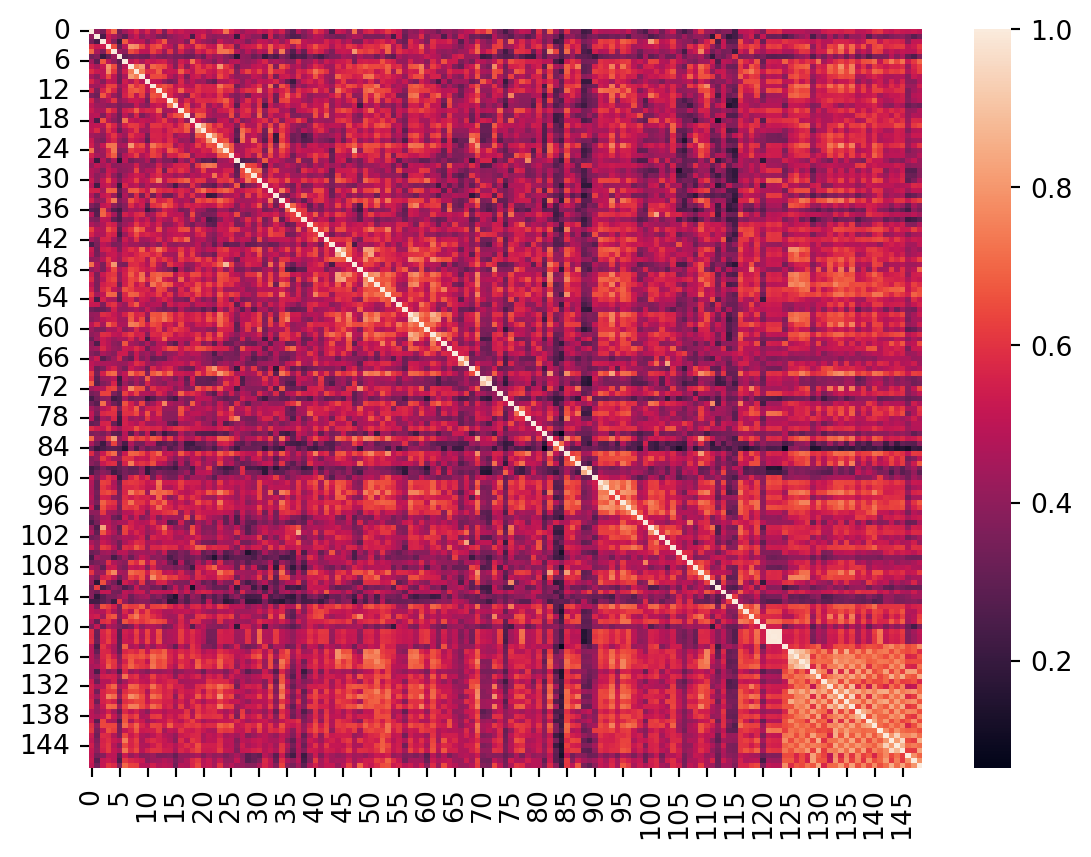

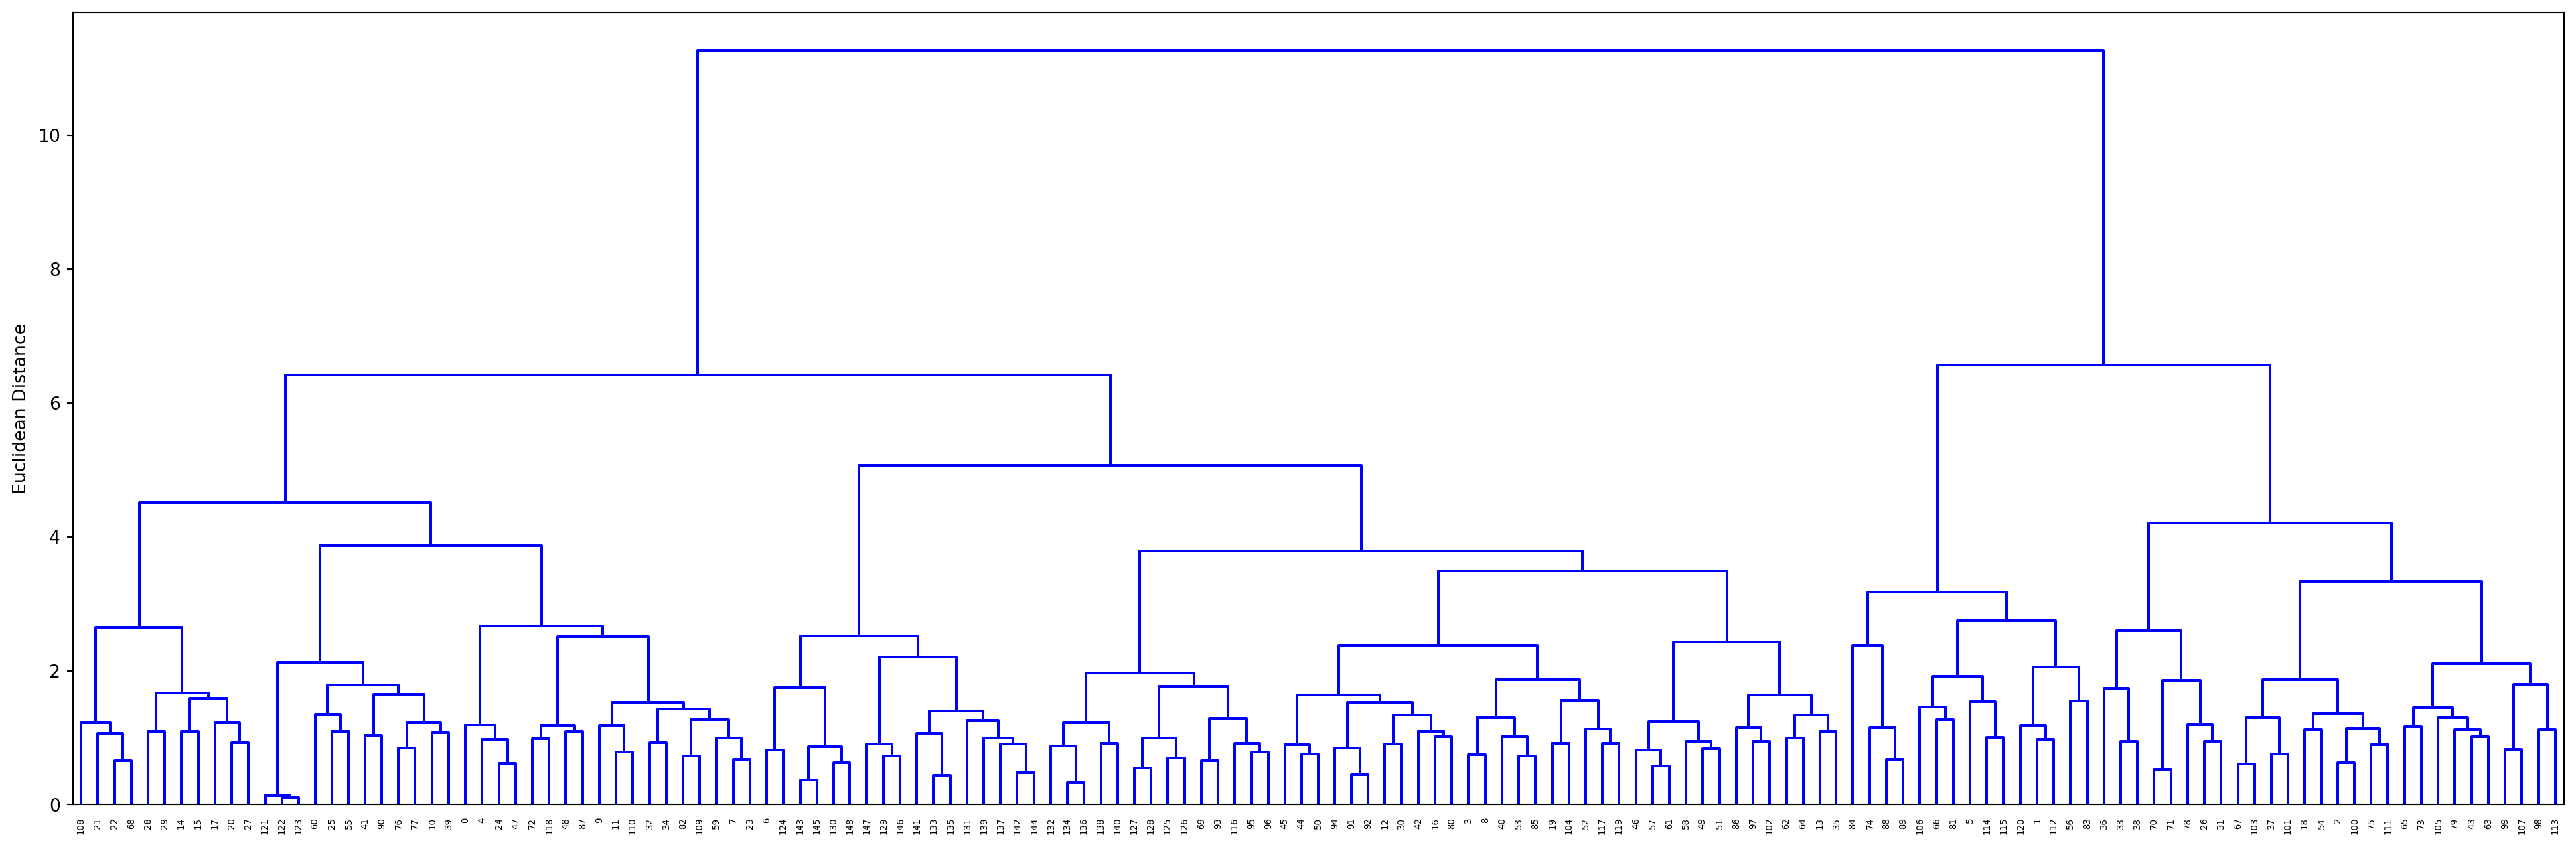

+-----------------------------------+-------------------------------------+----------+
| CBCL                              |                                     |          |
+===================================+=====================================+==========+
| Sentence 1                        | Sentence 2                          | Question |
+-----------------------------------+-------------------------------------+----------+
| 113A. Has other problem           | 113B. Has other problem             | 0.99     |
+-----------------------------------+-------------------------------------+----------+
| 113A. Has other problem           | 113C. Has other problem             | 0.99     |
+-----------------------------------+-------------------------------------+----------+
| 113B. Has other problem           | 113C. Has other problem             | 0.99     |
+-----------------------------------+-------------------------------------+----------+
| Internalizing T Score             | Exter

In [3]:
feature_specs = ['features-Parent_Measures-Demographic_Questionnaire_Measures-Child_Behavior_Checklist-CBCL-spec.json']

# get answers
df_A = get_answers(feature_specs)[0]

# get questions
df_Q = get_questions(feature_specs)[0]

# sentences
sentences = df_Q['Question'].tolist()

# calculate sentence similarity
cosine_scores, pairs = sentence_similarity(sentences)

# plot heatmap
plot_heatmap(array=cosine_scores, labels=None)

# plot dendrogram
dendrogram_plot(dataframe=cosine_scores)

# plot distribution of scores
scores = [r['score'].tolist() for r in pairs]
sns.histplot(scores)
plt.show()

# plot table
plot_top_sentences(pairs, sentences, A_similarity=None, percent=10, title='CBCL')


## TO DO 1

- Repronimschema for HBN (similar to ABCD), this should be a project for an RA (this will make it so much easier to do sentence transformation work)
- add preamble for more context
- tdif similarity - check this comparison with sentenceBert (do the results always form a bellcurve?)
- what kinds of constructs are being evaluated?
- Compare responses across two questionnaires (get correlation distance between two matrices `dcorr`) - number of rows must be the same, but the number of columns can be different
- hierarchical clustering on the cosine similarity matrix (of sentences) to determine whether there are clusters that fall out (look both at sentences and responses, are these clusters in alignment?)
- compare certain "clusters" across questionnaires - anxiety items on CBCL and GAD7 (or anxiety questionnaire). To what extent are they measuring the same construct?
- can we get a correlation across items per participant? rather than focus on the group level zoom in on the individual
- figure: compare parent vs. teacher vs. child predictions


## TO DO 2

- individual level: sign of response between parent + teacher - how do they differ more on subsets of item. do they map onto different clusters of ADHD. is there an item-level breakdown
- part x quesstions: reordr hte rows based on hierarchical clutering (and vice vera), value of matrix - difference between parent and teacher
- compare clinical diagnoses across 

## Compare answer similarities across questionnaires

In [4]:
feature_specs = ['features-Parent_Measures-Demographic_Questionnaire_Measures-Child_Behavior_Checklist-CBCL-spec.json',
                'features-Teacher_Measures-domains-Child_Behavior_Checklist_–_Teacher_Report_Form-TRF-spec.json']

# get answers
df_A = get_answers(feature_specs)

x = df_A[0]; y = df_A[1]


## Calculate distance correlation between two questionnaires (CBCL-Parent and CBCL-Teacher)

In [5]:
dcor.distance_correlation(x, y)

0.31449558403499905

## The distance correlation t-test of independence

In [6]:

dcor.independence.distance_correlation_t_test(x, y)

HypothesisTest(pvalue=0.0, statistic=15.804851212251073)

As we can observe, this test correctly rejects the null hypothesis in the second case and not in the first case.

The test illustrated here is an asymptotic test, that relies in the approximation of the statistic distribution to the Student’s t-distribution under the null hypothesis, when the dimension of the data goes to infinity. This test is thus faster than permutation tests, as it does not require the use of permutations of the data, and it is also deterministic for a given dataset. However, the test should be applied only for high-dimensional data, at least in theory.

We will now plot for the case of normal distributions the histogram of the statistic, and compute the Type I error, as seen in Székely and Rizzo1. Users are encouraged to download this example and increase that number to obtain better estimates of the Type I error. In order to replicate the original results, one should set the value of n_tests to 1000.

## Permutation test of distance correlation

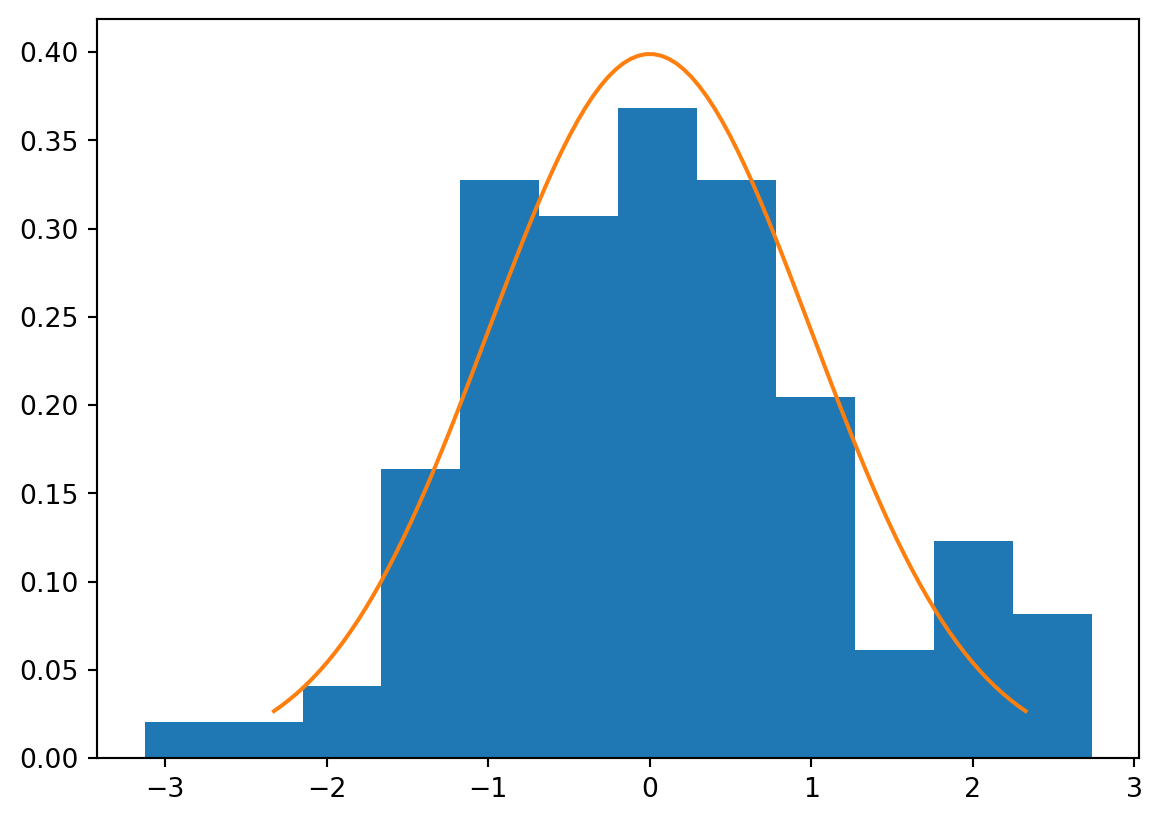

In [7]:
distance_correlation_permutation(x,y)

## The distance covariance test of independence

In [8]:
random_state = np.random.default_rng(83110)
dcor.independence.distance_covariance_test(
    x,
    y,
    num_resamples=200,
    random_state=random_state,
)

HypothesisTest(pvalue=0.004975124378109453, statistic=213.46578868208118)

We can see that the p-value obtained is indeed very small, and thus we can safely reject the null hypothesis, and consider that there is indeed dependence between the random vectors.

The next test illustrated here is a permutation test, which compares the distance covariance of the original dataset with the one obtained after random permutations of one of the input arrays. Thus, increasing the number of permutations makes the p-value more accurate, but increases the computational cost. 

## Permutation test of distance covariance

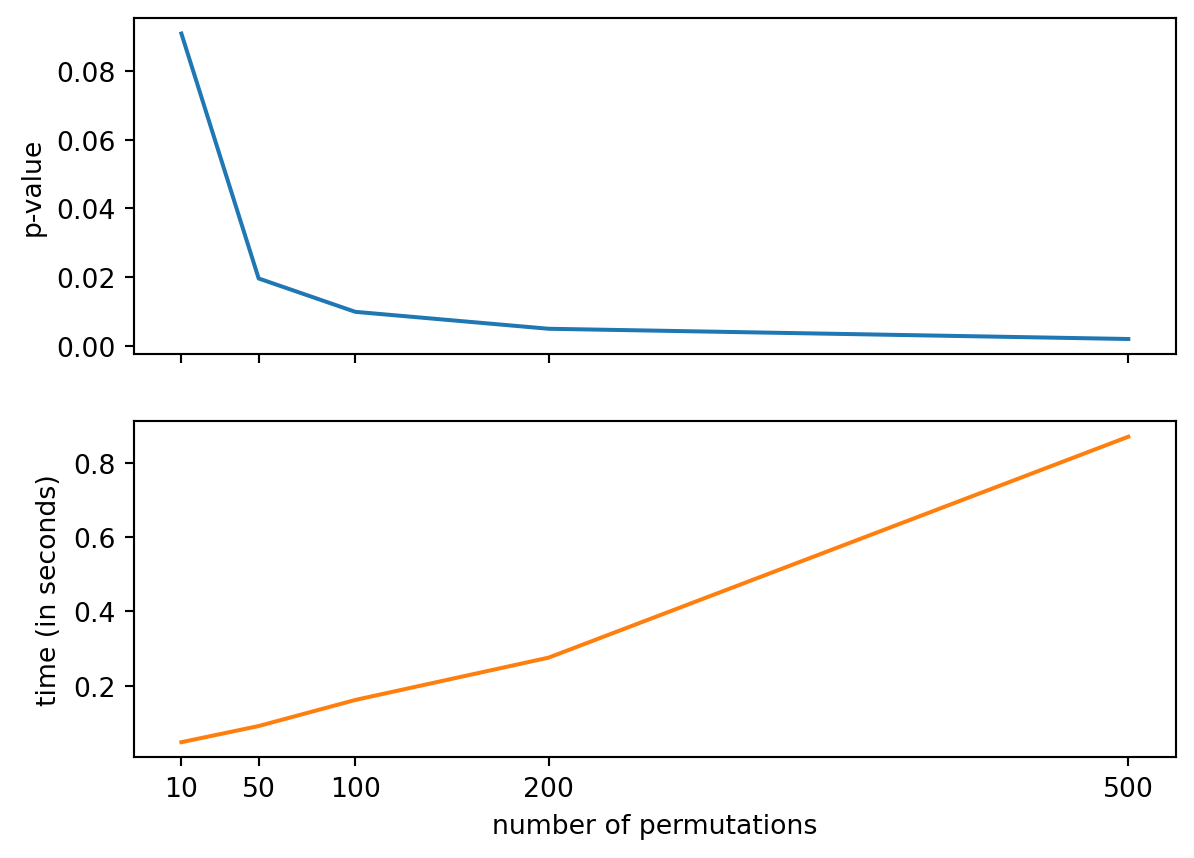

In [9]:
distance_covariance_permutation(x,y)

## Monte Carlo Test - get estimates of Type I error

We generate independent data following a multivariate Gaussian distribution as well as different 
t(v) distributions. In all cases we consider random vectors with dimension 5. We perform the tests for different number of observations, computing the number of permutations used as [200 + 5000/n]. We fix the significance level to 0.1.

In [10]:
# monte carlo test
#monte_carlo_test(x,y)

## Compare Questionnaires - Answers

Text(0.5, 1.0, 'Language_Tasks')

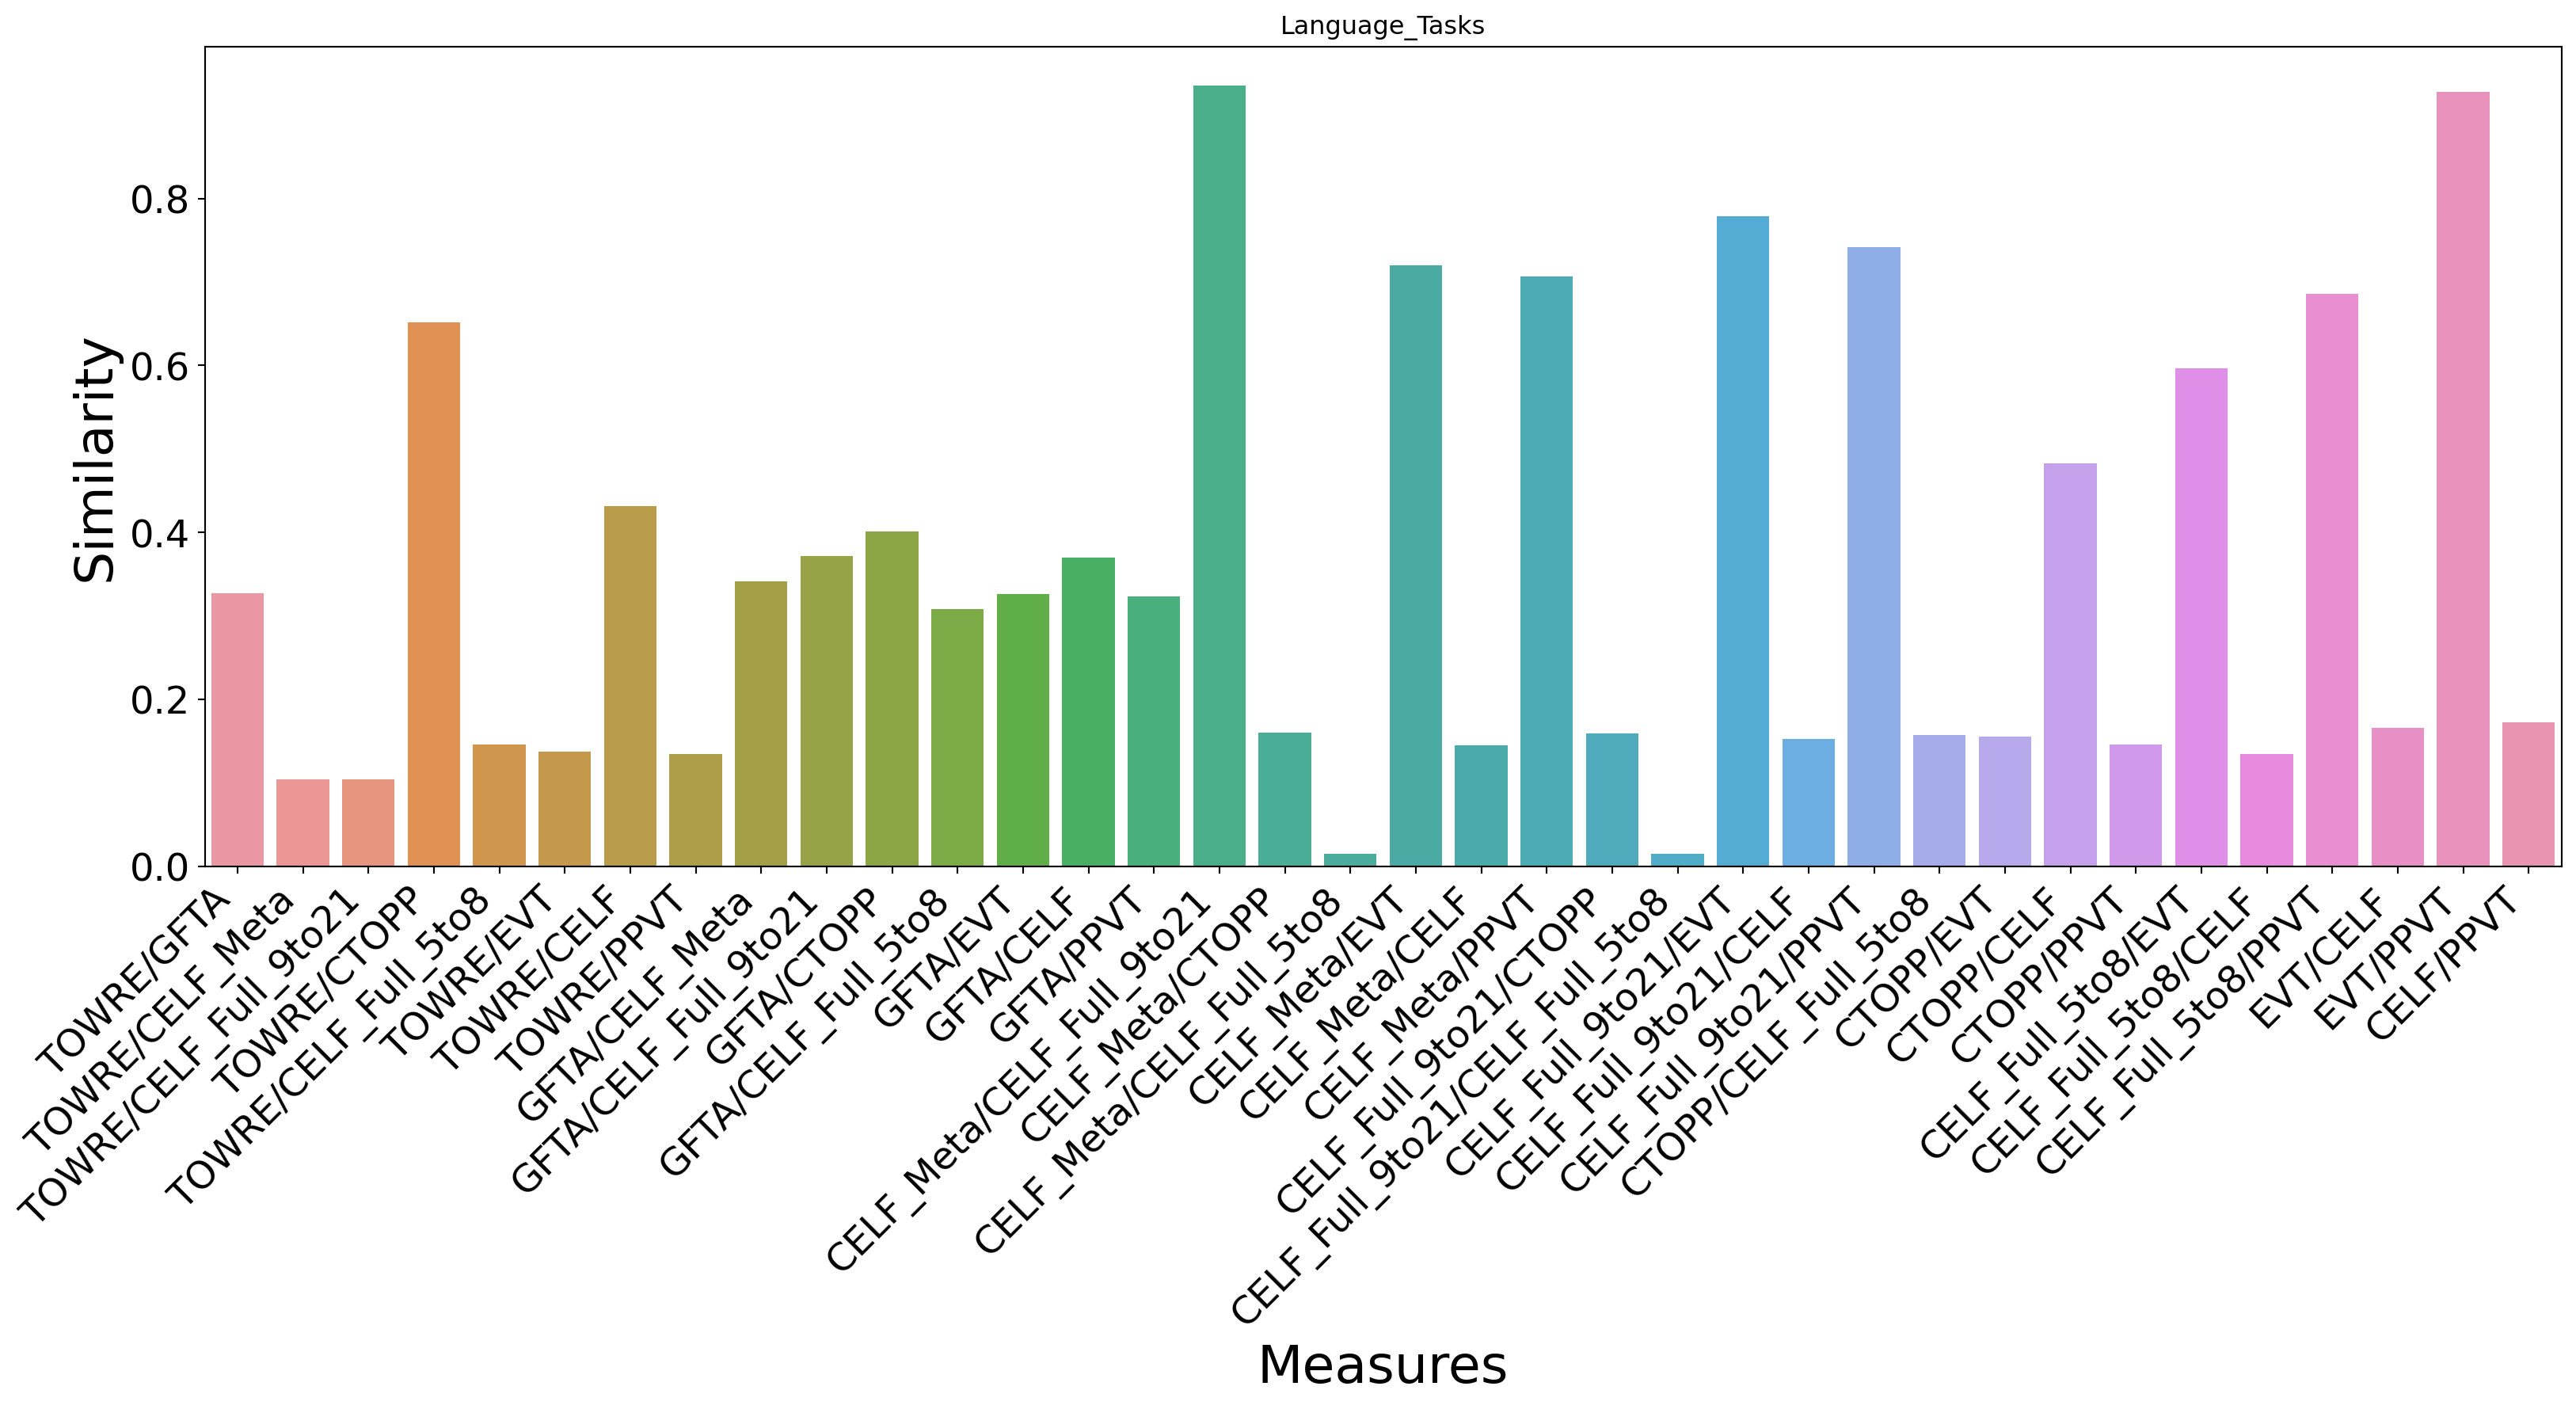

In [11]:
# plot figure 

domain = 'Language_Tasks'

df = compare_answers(domain)

plt.figure(figsize=(20,7))
sns.barplot(x='measures', y='distance', data=df)
plt.xticks(rotation=45, ha='right');
plt.tick_params(axis='both', which='major', labelsize=18);
plt.xlabel('Measures', fontsize=25)
plt.ylabel('Similarity', fontsize=25);
plt.title(domain)

Text(0.5, 1.0, 'Physical_Fitness')

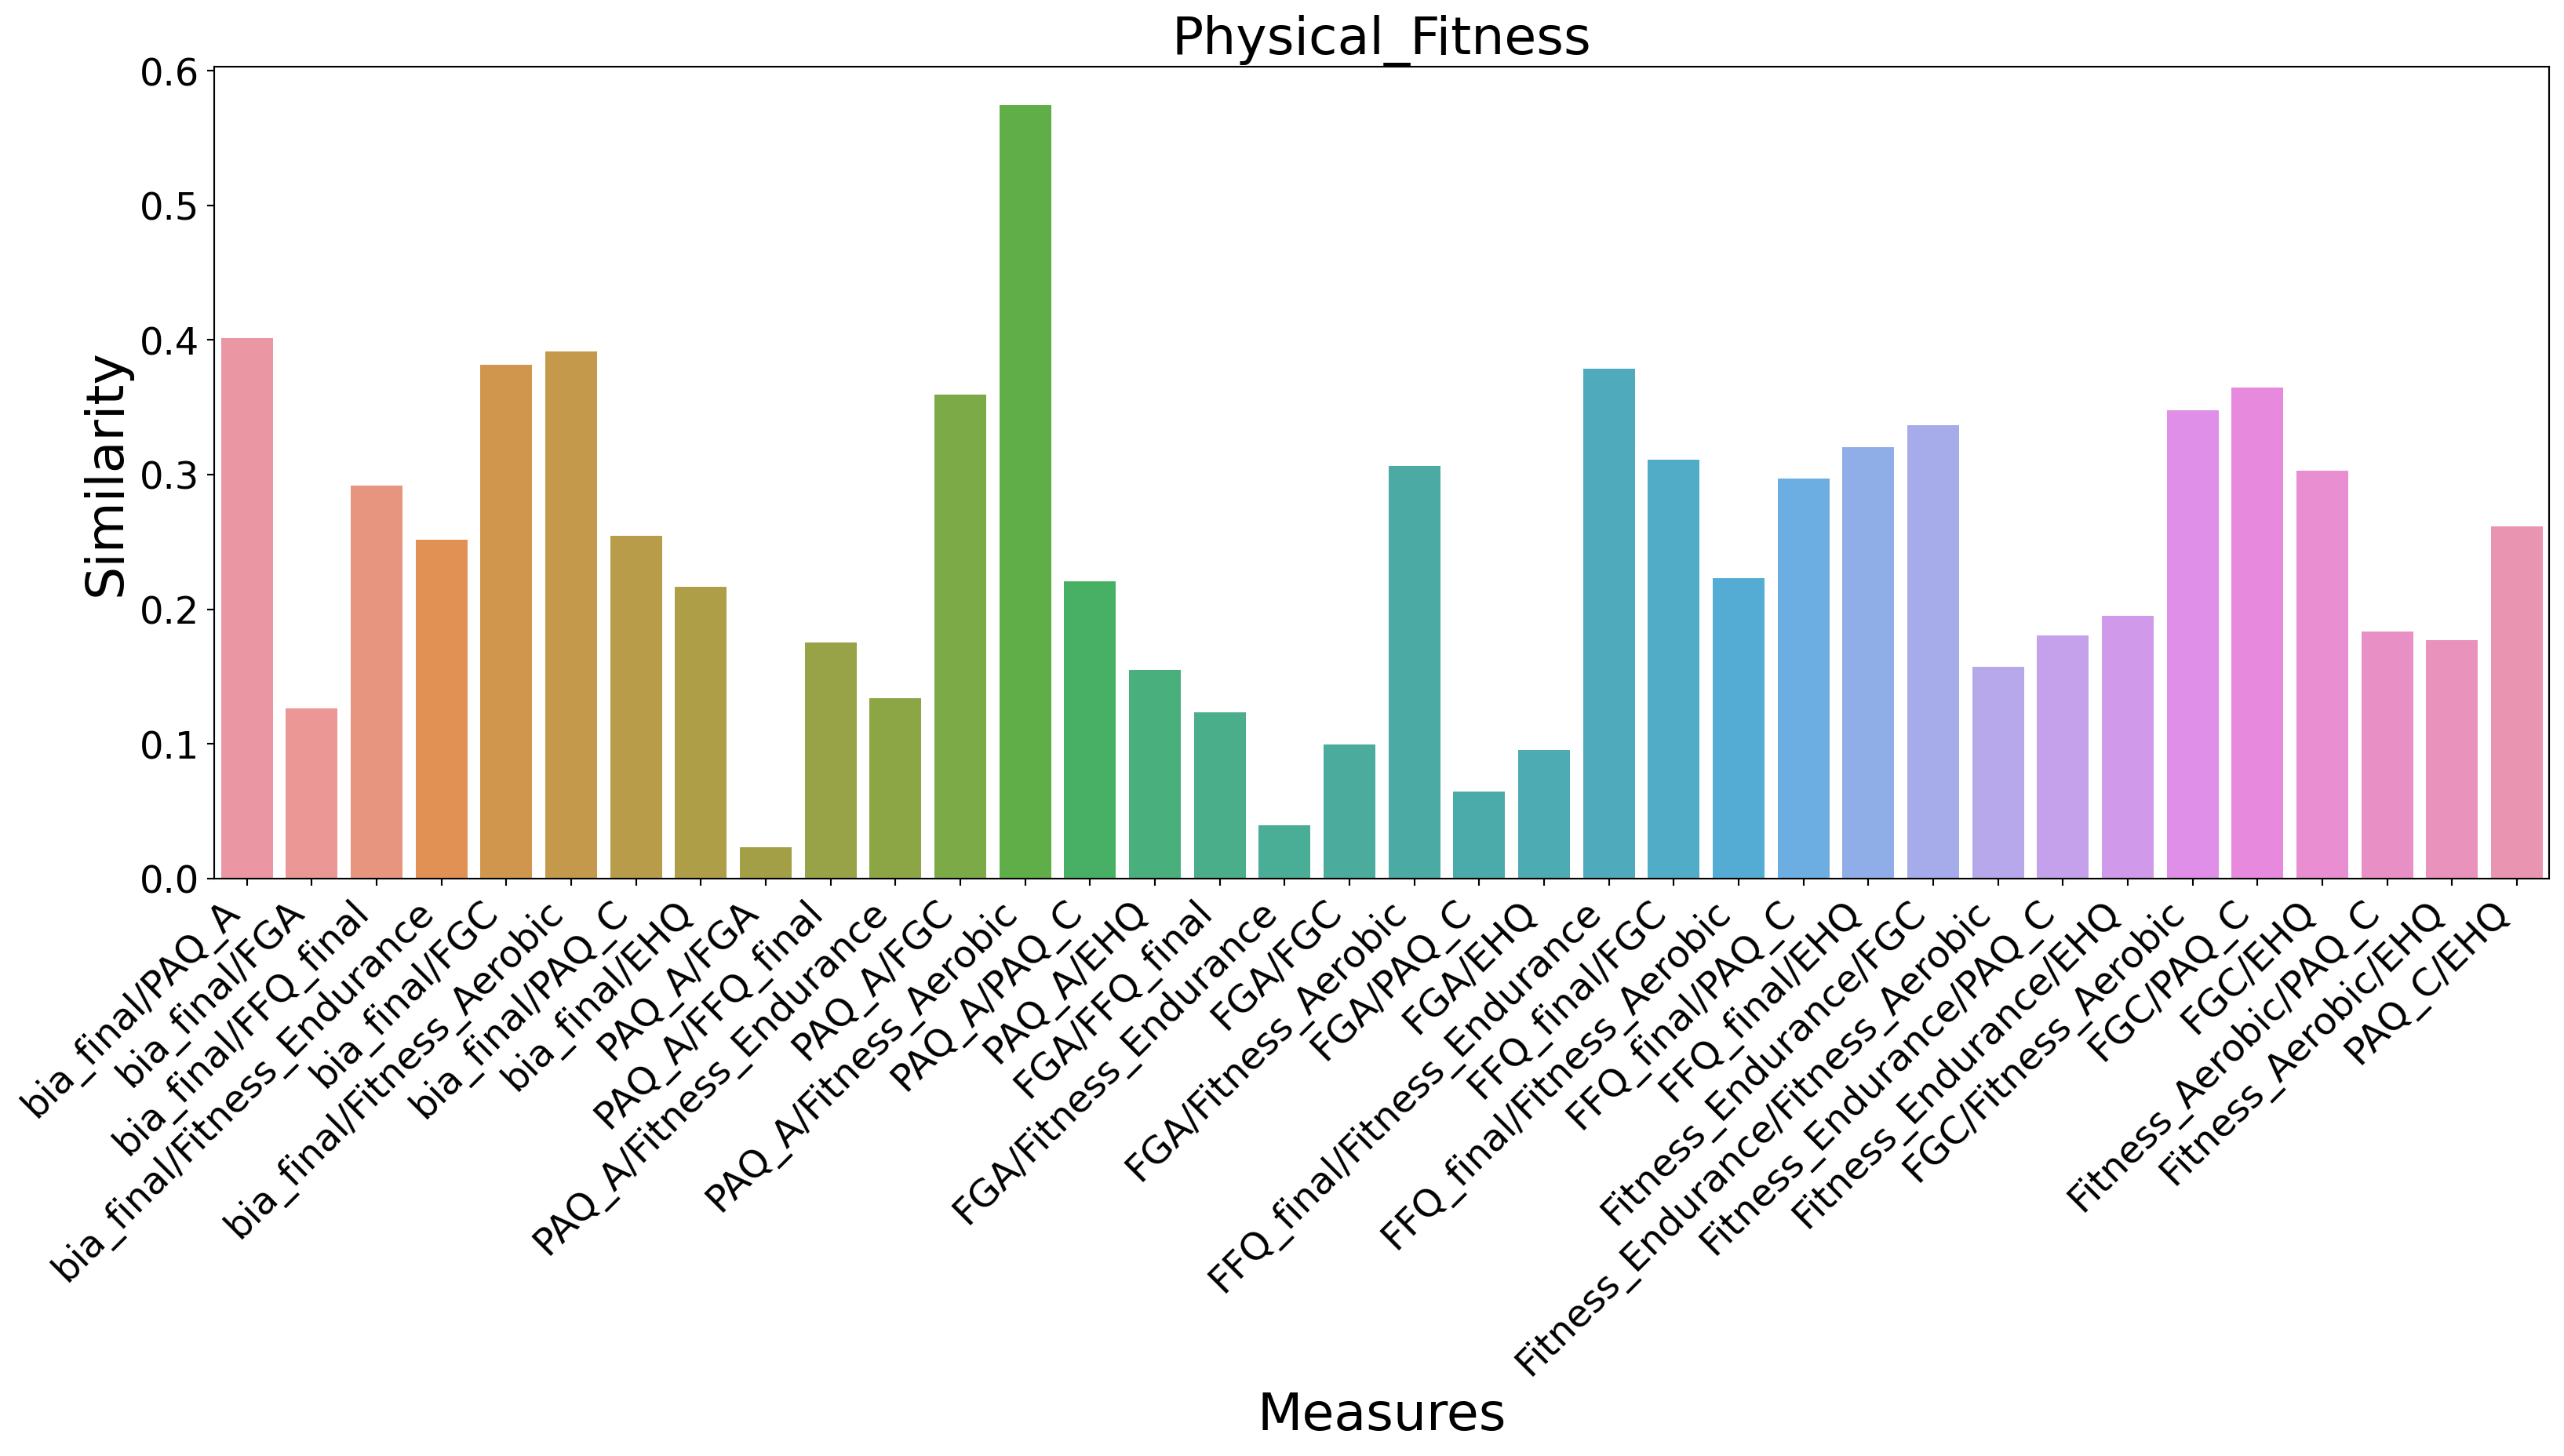

In [12]:
# plot figure 

domain = 'Physical_Fitness'

df = compare_answers(domain)

plt.figure(figsize=(20,7))
sns.barplot(x='measures', y='distance', data=df)
plt.xticks(rotation=45, ha='right');
plt.tick_params(axis='both', which='major', labelsize=18);
plt.xlabel('Measures', fontsize=25)
plt.ylabel('Similarity', fontsize=25);
plt.title(domain, fontsize=25)

Text(0.5, 1.0, 'Child_Behavior_Checklist')

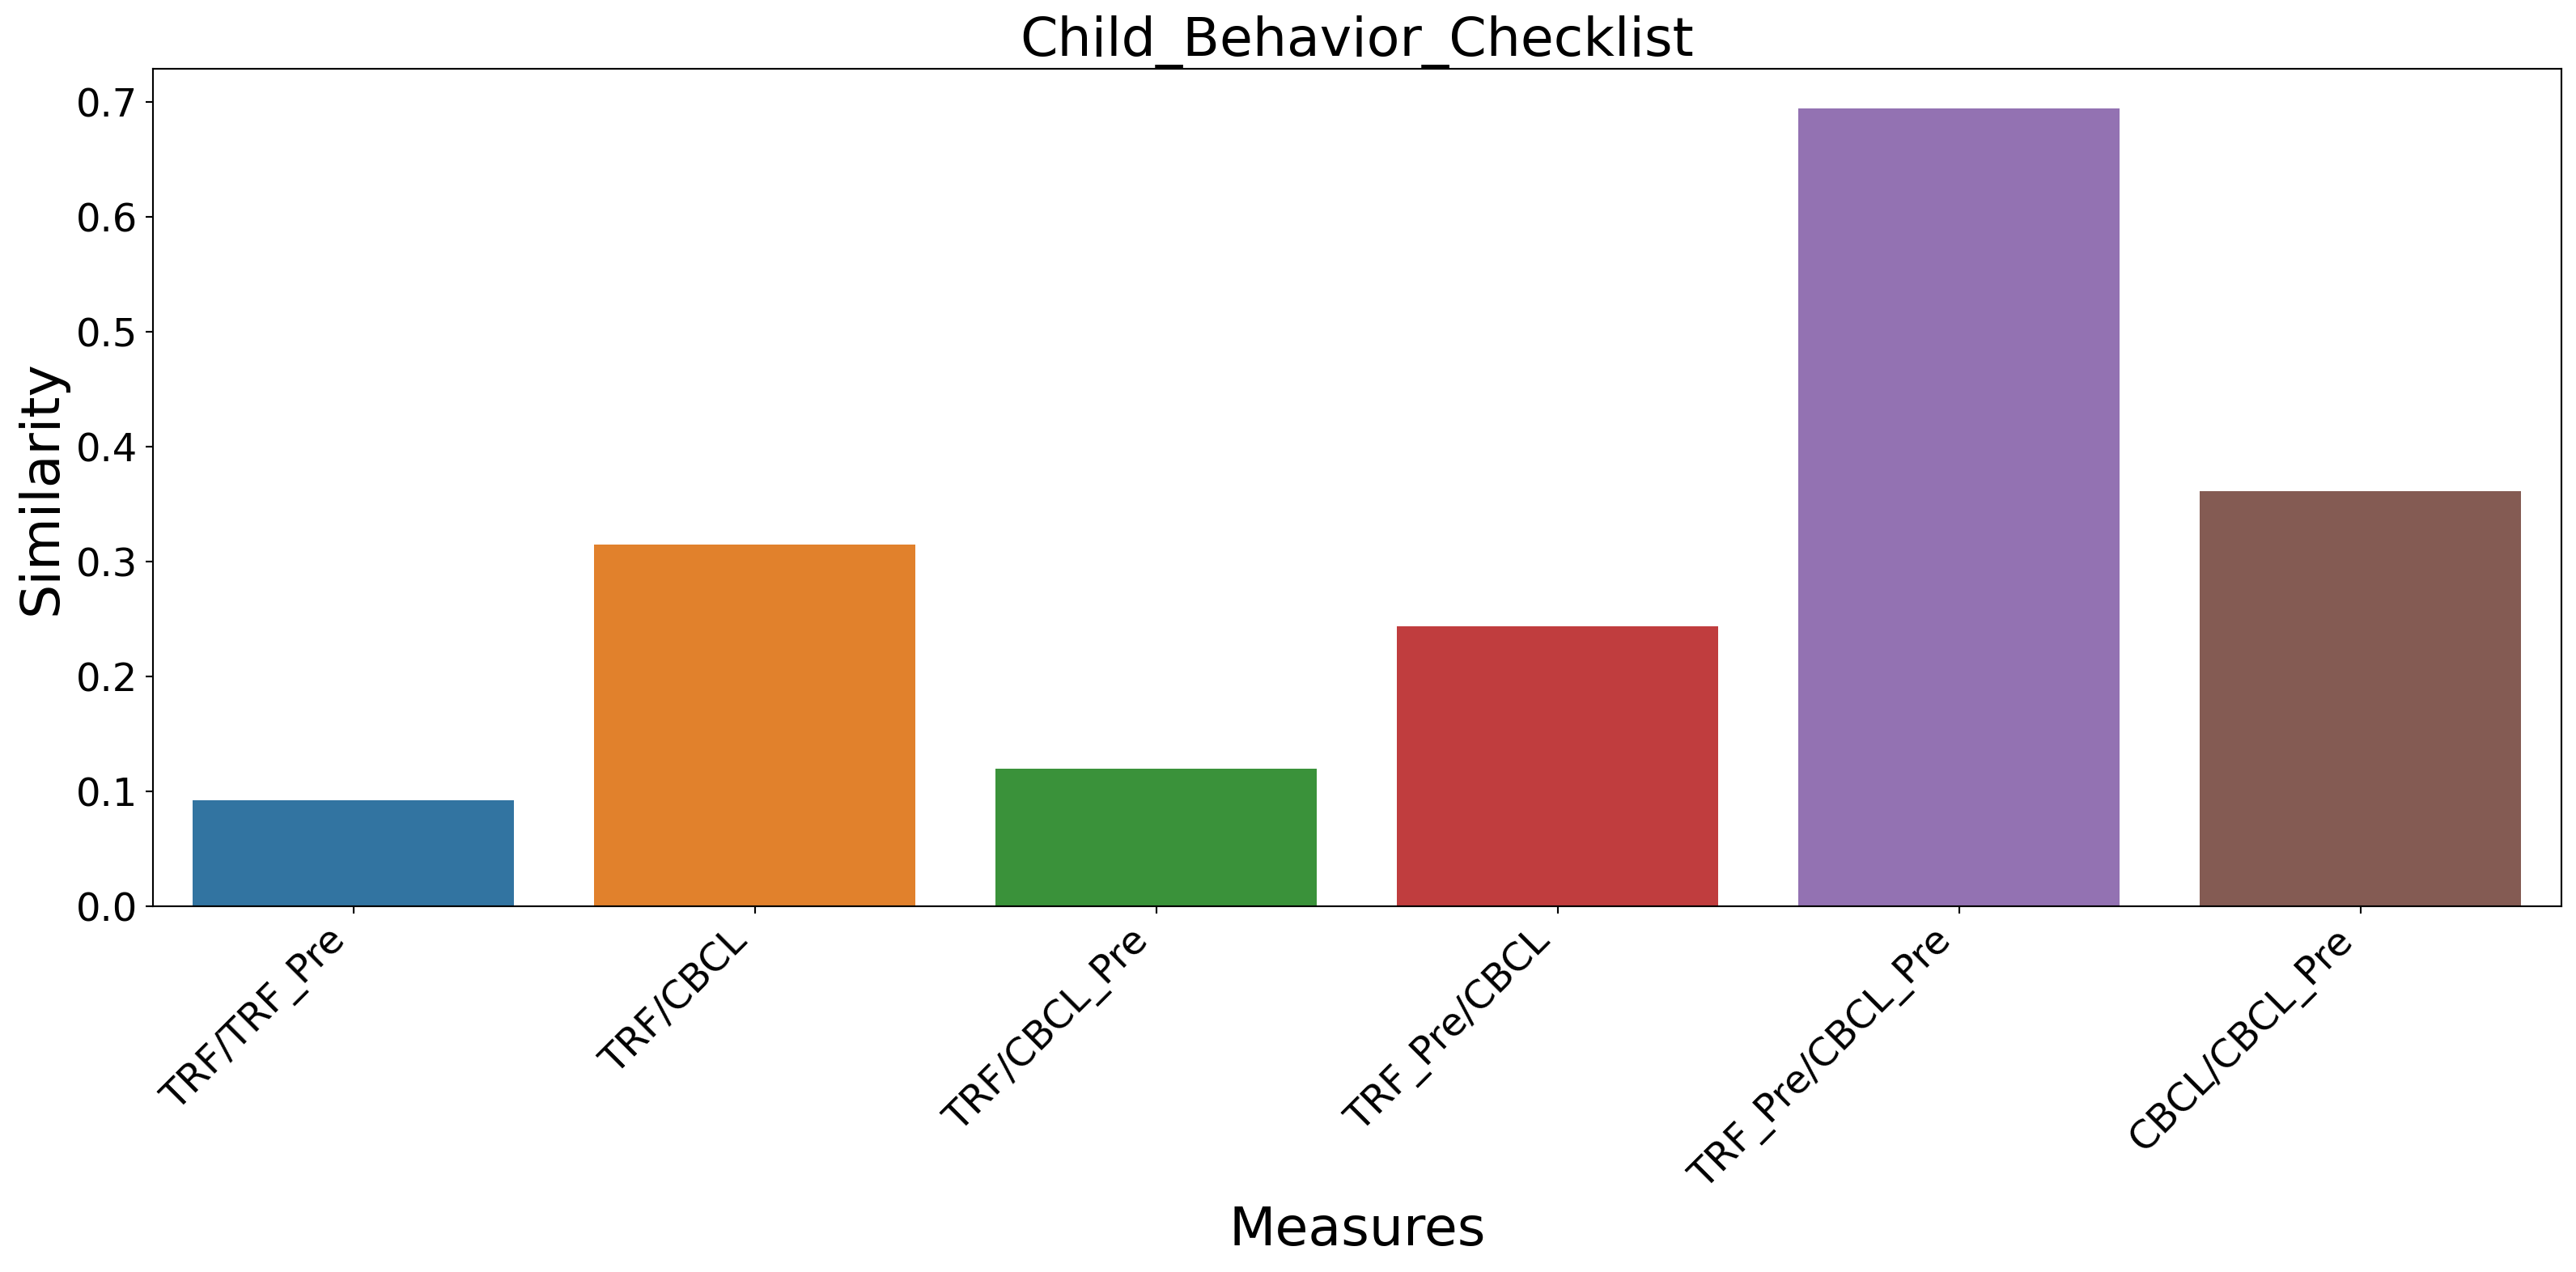

In [13]:
# plot figure 

domain = 'Child_Behavior_Checklist'

df = compare_answers(domain)

plt.figure(figsize=(20,7))
sns.barplot(x='measures', y='distance', data=df)
plt.xticks(rotation=45, ha='right');
plt.tick_params(axis='both', which='major', labelsize=18);
plt.xlabel('Measures', fontsize=25)
plt.ylabel('Similarity', fontsize=25);
plt.title(domain, fontsize=25)

## compare across age brackets

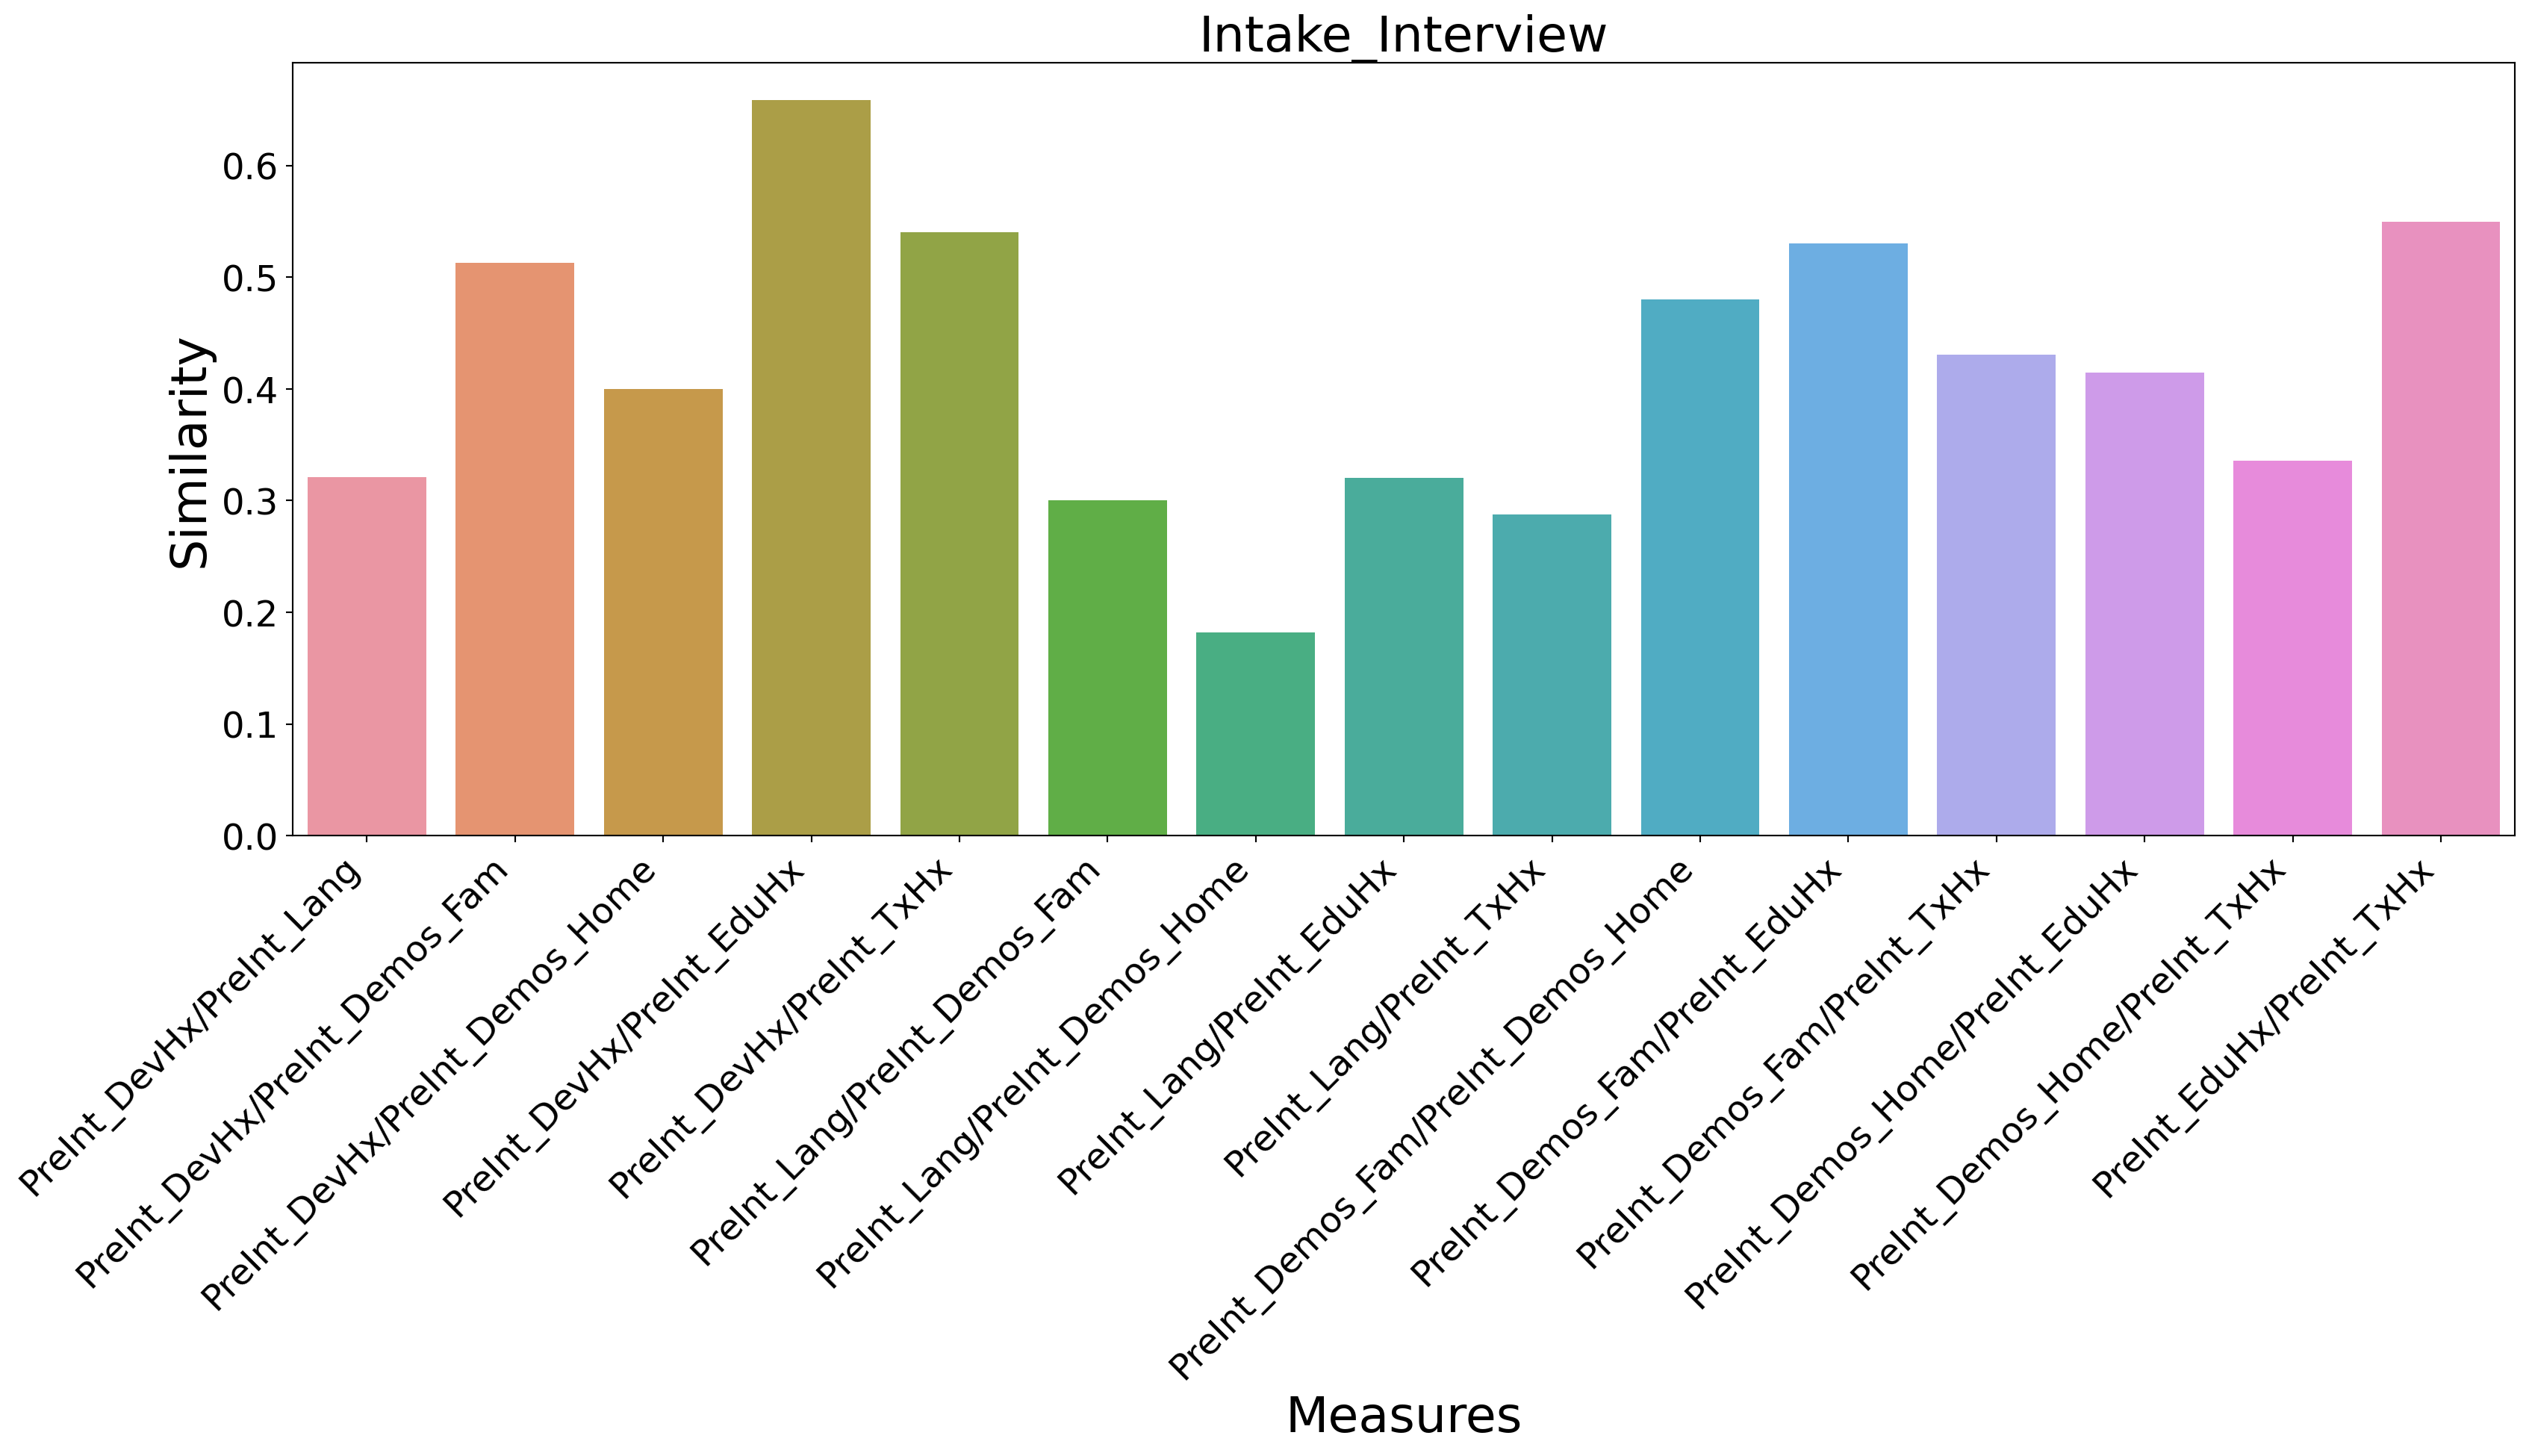

In [14]:
domain = None
measure = 'Intake_Interview'

df = compare_answers(domain=measure, measure=measure)

plt.figure(figsize=(20,7))
sns.barplot(x='measures', y='distance', data=df)
plt.xticks(rotation=45, ha='right');
plt.tick_params(axis='both', which='major', labelsize=18);
plt.xlabel('Measures', fontsize=25)
plt.ylabel('Similarity', fontsize=25);
plt.title(measure, fontsize=25);

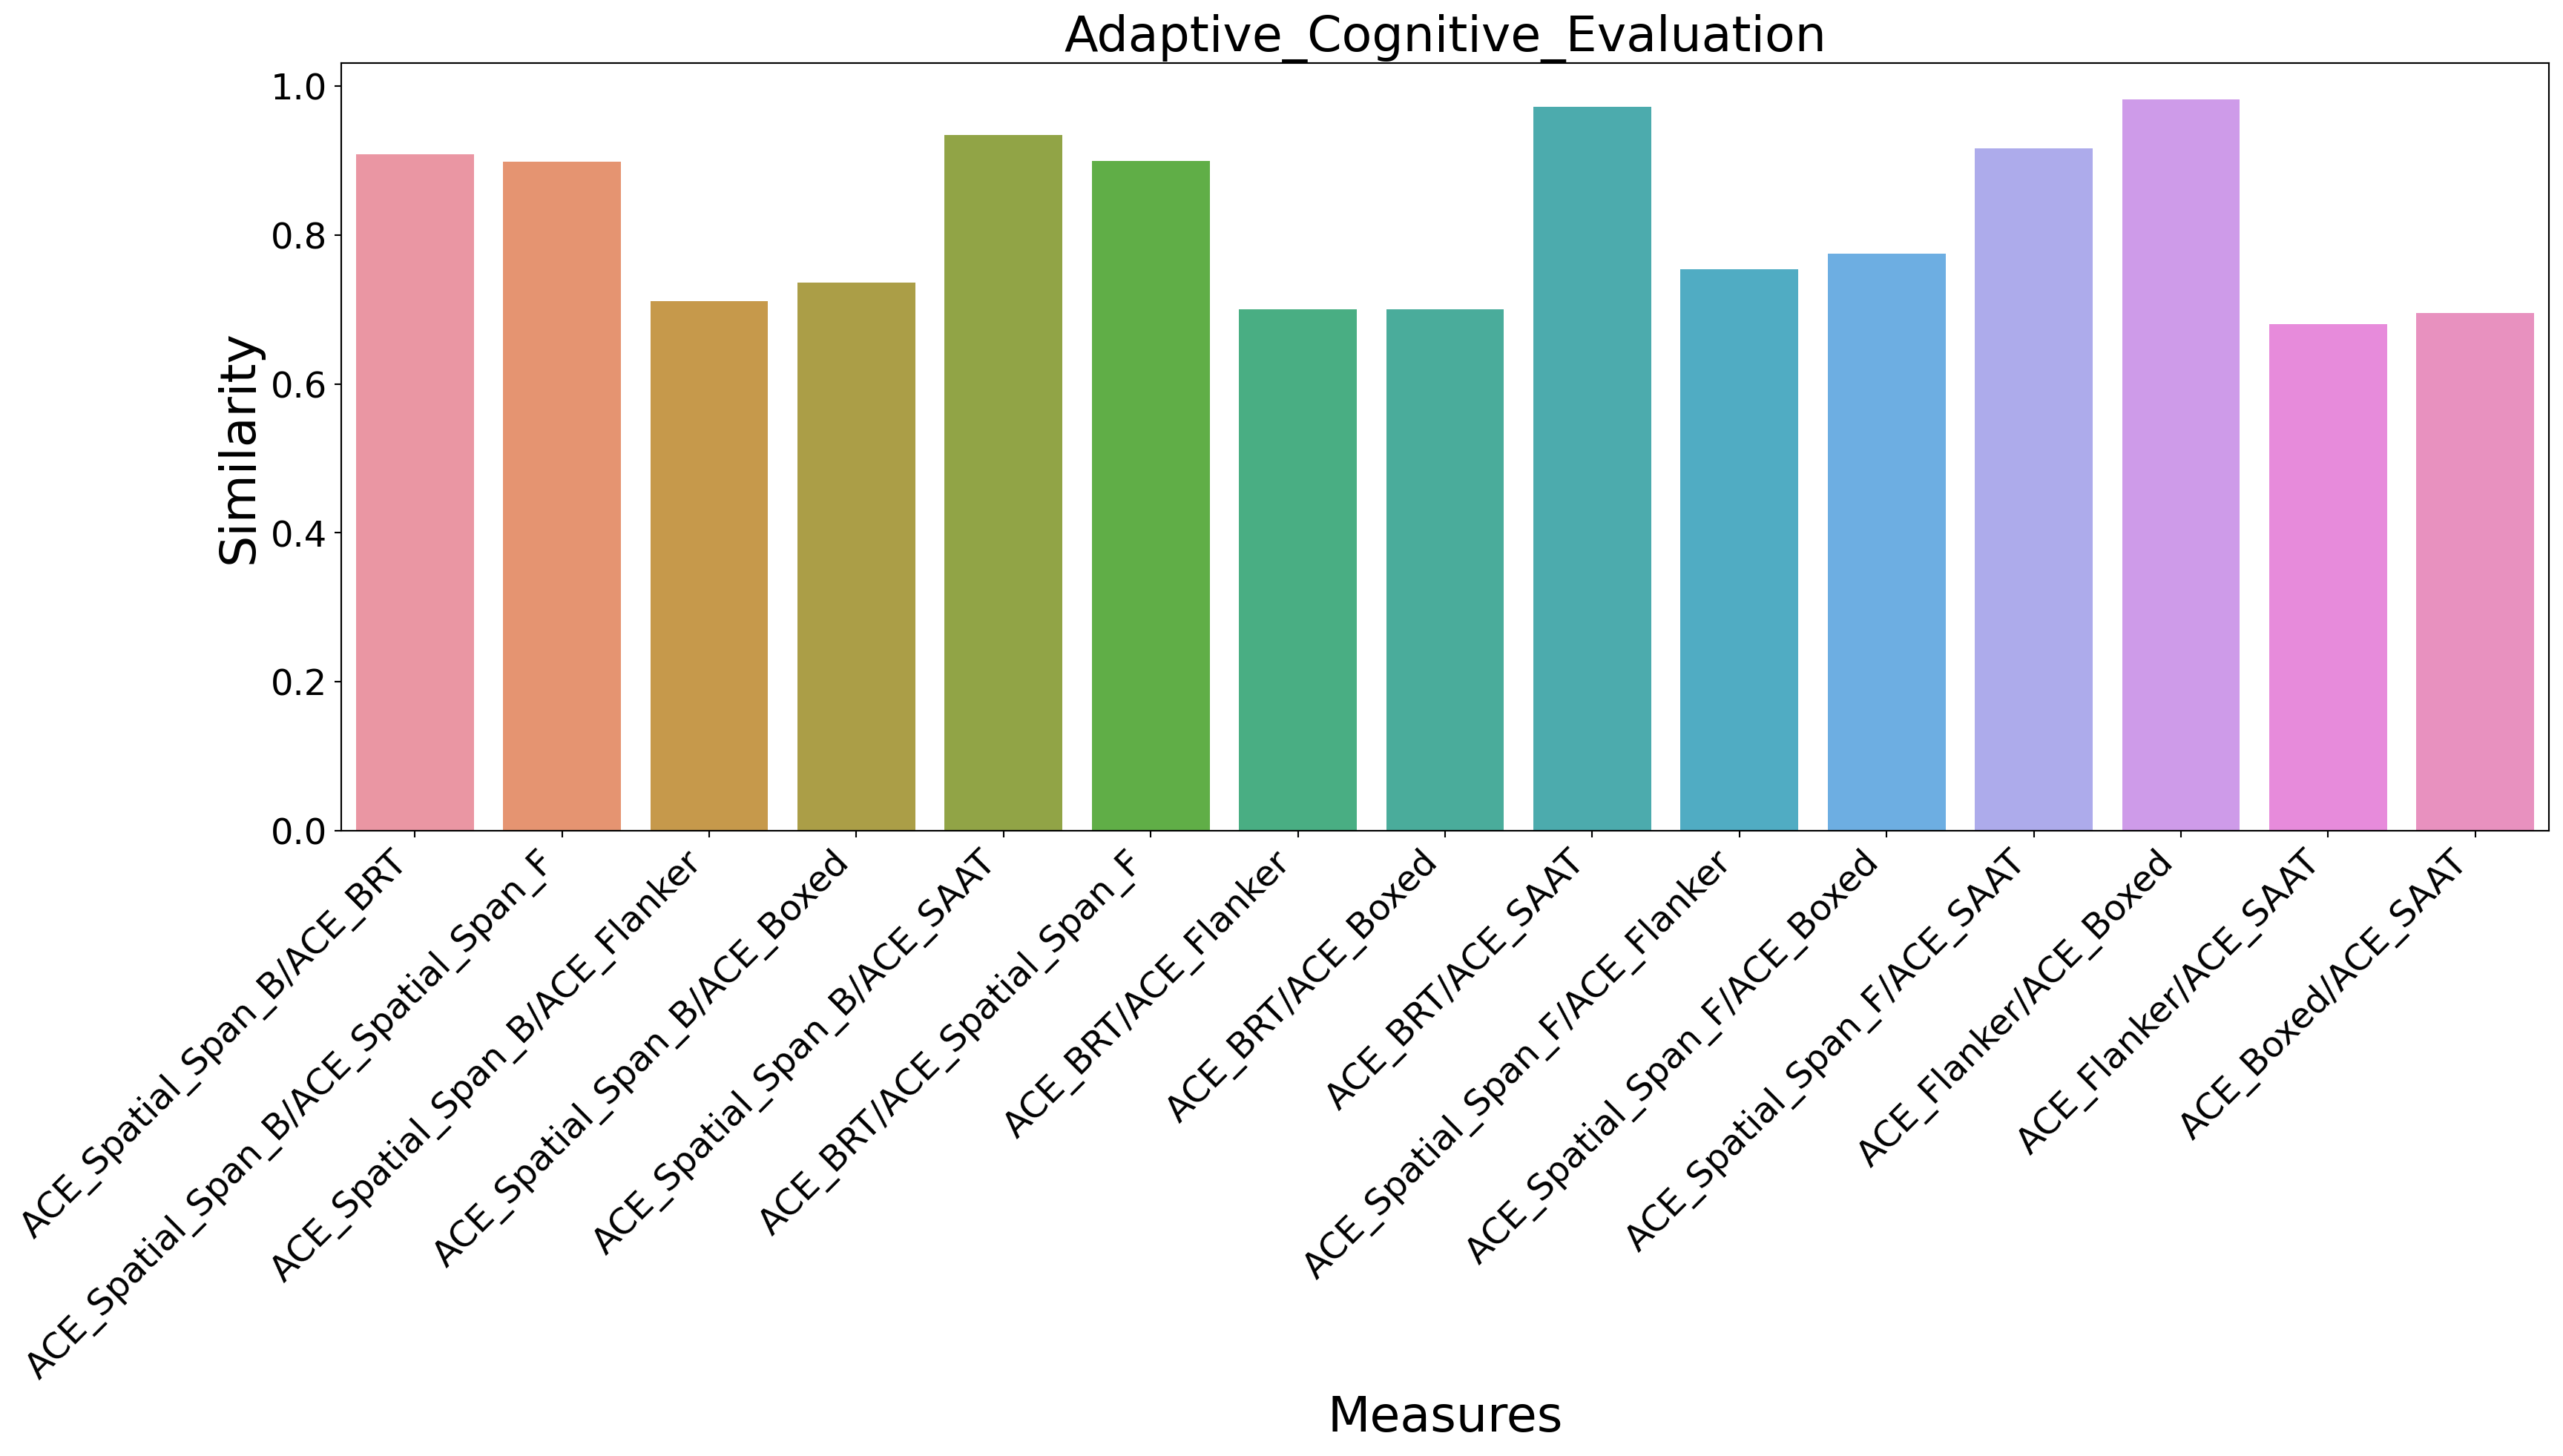

In [15]:
domain = None
measure = 'Adaptive_Cognitive_Evaluation'

df = compare_answers(domain=measure, measure=measure)

plt.figure(figsize=(20,7))
sns.barplot(x='measures', y='distance', data=df)
plt.xticks(rotation=45, ha='right');
plt.tick_params(axis='both', which='major', labelsize=18);
plt.xlabel('Measures', fontsize=25)
plt.ylabel('Similarity', fontsize=25);
plt.title(measure, fontsize=25);

## Compare answers across diagnoses for CBCL (Parent + Teacher)

In [16]:

diagnoses = ['ADHD', 'Anxiety_Disorders', 'Autism_Spectrum_Disorder', 'Specific_Learning_Disorder_with_Impairment_in_Reading']

df_all = pd.DataFrame()
for diagnosis in diagnoses:
    for (domain, measure) in zip(['Child_Behavior_Checklist', None], [None, 'Youth_Self_Report']):
        df = compare_answers(domain=domain, measure=measure, diagnoses=[diagnosis], split='all')
        df['diagnosis'] = diagnosis
        df_all = pd.concat([df_all, df])
        print(f"adding {diagnosis} to dataframe")


adding ADHD to dataframe
adding ADHD to dataframe


adding Anxiety_Disorders to dataframe
adding Anxiety_Disorders to dataframe


adding Autism_Spectrum_Disorder to dataframe
adding Autism_Spectrum_Disorder to dataframe


adding Specific_Learning_Disorder_with_Impairment_in_Reading to dataframe
adding Specific_Learning_Disorder_with_Impairment_in_Reading to dataframe


In [17]:
import plotly.express as px

df = df_all[df_all['measures'].isin(['TRF/CBCL', 'TRF_Pre/CBCL_Pre'])]
df = df.replace({'TRF/CBCL': 'Teacher vs. Parent', 'TRF_Pre/CBCL_Pre': 'Teacher (Preschool) vs. Parent (Preschool)'})
df = df.replace({'Anxiety_Disorders': 'Anxiety', 
            'Autism_Spectrum_Disorder': 'ASD', 
            'Specific_Learning_Disorder_with_Impairment_in_Reading': 'Reading Impairment',
            }
          )


fig = px.line_polar(df, r="distance", 
                    theta="diagnosis", 
                    color="measures", 
                    line_close=True, 
                    range_r=[df_all['distance'].min(), df_all['distance'].max()]
                   ) 
fig.show()

## Compare diagnoses across age for CBCL (Parent + Teacher)

### TO DO